In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "..")
from outliers_test import DopingOutliersTest

### Collect a dataset from OpenML

In [2]:
data = fetch_openml('breast-w', version=1)
df = pd.DataFrame(data.data, columns=data.feature_names)

### Use DopingOutliersTest to tranform the data into a format with known outliers

In [3]:
data_modifier = DopingOutliersTest()
df_modified, outlier_scores = data_modifier.transform(df, random_state=0, verbose=False)

### Function to provide Count Encoding for categorical values

In [4]:
# This example uses Isolation Forest, which works strictly with numeric values,
# requiring all categorical values to be either dropped or encoded. There
# are many possible encoders, such as one-hot, label etc, but Count Encoding
# tends to work well with outlier detection. Count Encoding is available in 
# python modules, but to minimize pip installs, and as it is very simple, it 
# is provided here.

def get_count_encoding(df):
    df = df.copy()
    for col_name in df.columns:
        if df[col_name].dtype.name in ['str', 'category', 'object']:
            df[col_name] = df[col_name].astype(str)
            vc = df[col_name].value_counts(dropna=False)
            df[col_name] = df[col_name].replace([None, np.nan, -np.nan, 'nan'], df[col_name].mode()[0])
            map_dict = {x: y for x, y in zip(vc.index, vc.values)}
            df[col_name] = df[col_name].map(map_dict)
            df[col_name] = df[col_name].astype(str)
    return df

### Get IsolationForest (IF) scores on original data

In [5]:
# We first encode the data in a format suitable for IF
df_encoded = get_count_encoding(df)
df_encoded = df_encoded.fillna(0)
df_encoded = df_encoded.replace([np.nan, -np.nan], 0)

det = IsolationForest(random_state=0)
det.fit(df_encoded)
y_orig_if = det.score_samples(df_encoded)

### Get IF scores on the modified dataset

In [6]:
df_modified_encoded = get_count_encoding(df_modified)
df_modified_encoded = df_modified_encoded.fillna(0)
df_modified_encoded = df_modified_encoded.replace([np.nan, -np.nan], 0)

det = IsolationForest(random_state=0)
det.fit(df_modified_encoded)
y_modified_if = det.score_samples(df_modified_encoded)

### Examine and compare the IF Scores

In [7]:
# The Doping Outliers Test tool cannot estimate how unusual any row is, 
# only how unusual it likely is compared to its state before the doping
# process. As such, to evaluate how well IF does in identifying the modified
# rows, we get the IF score of each row before and after the doping process
# and examine the difference in IF scores.

# As IF is known to be a strong outlier detector, the gains in outlier scores
# for the modified rows should be higher than for the unmodified rows, which
# is, in fact, the case. 

# IF gives more negative scores to more anomalous rows. To examine the outlierness
# of each row in positive terms, we multiply each score by -1.

df_modified['IF Orig Score'] = y_orig_if * (-1)
df_modified['IF Modified Score'] = y_modified_if * (-1)
df_modified['IF Gain'] = df_modified['IF Modified Score'] - df_modified['IF Orig Score']
df_modified['IF Gain Cleaned'] = df_modified['IF Gain'].apply(lambda x: 0 if x <= 0.0 else x)

In [8]:
# Store the outlier score estimated by the doping tool
df_modified['OUTLIER SCORE'] = outlier_scores

In [9]:
# Print the correlations

# The scores on the original and modified datasets are very similar, as only a small number of
# rows were modified. However, they are different.
print("Spearman Correlation Orig to Modified IF scores: ",
      scipy.stats.spearmanr(df_modified['IF Orig Score'], df_modified['IF Modified Score'])[0])

# The IF scores (once cleaned) correlate very closely with the estimated scores produced by 
# the Doping Outlier Tester tool.
print("Spearman Correlation Gain IF scores to Estimated Scores: ",
      scipy.stats.spearmanr(df_modified['IF Gain Cleaned'], df_modified['OUTLIER SCORE'])[0])

Spearman Correlation Orig to Modified IF scores:  0.9788390090419434
Spearman Correlation Gain IF scores to Estimated Scores:  0.9141700765210943


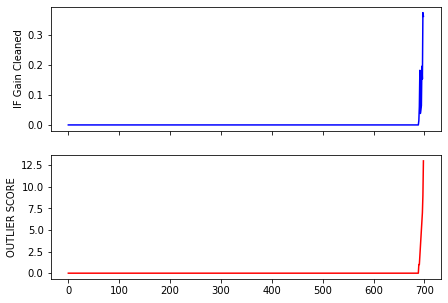

In [10]:
# This plots the scores. It can be seen the y are well correlated, 
# though the scores from the isolation forest are not completely 
# monotonically related to the estimated scores from the Doping 
# Outlier Tester, as expected, as the Doping Outlier Detector can
# not estimate accurately how much more unusual a modified row will be 
# considered by any given outlier detector. 

df_modified = df_modified.sort_values(['OUTLIER SCORE'])
df_modified = df_modified.reset_index()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(7, 5))
s = sns.lineplot(x=df_modified.index, y=df_modified['IF Gain Cleaned'], color='blue', ax=ax[0])
s = sns.lineplot(x=df_modified.index, y=df_modified['OUTLIER SCORE'], color='red', ax=ax[1])
plt.show()

In [11]:
# Display the specific gain in IF score and estimate outlier score
# for the 10 rows modified as well as 10 other rows. We see both
# are non-zero in the same rows. This is not strictly true for
# all datasets, but tends to be the case. 

df_modified = df_modified.sort_values(['OUTLIER SCORE'], ascending=False)
df_modified[['IF Gain Cleaned', 'OUTLIER SCORE']].head(20)

,IF Gain Cleaned,OUTLIER SCORE
698,0.360403,13
697,0.372815,9
696,0.152334,7
695,0.194779,6
694,0.063895,5
693,0.051396,4
692,0.038045,3
691,0.181342,2
689,0.014162,1
690,0.061157,1
